# ex 3
Write a function/script that estimates α and spectral measure Γ for a given sample

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as st
from basic_units import radians, degrees, cos

sns.set()
pi = np.pi

In [7]:
def stable_random_variables_a(alpha):
    if alpha == 1:
        Omega = np.random.uniform(-pi/2, pi/2)
        return np.tan(Omega)
    else:
        Omega = np.random.uniform(-pi/2, pi/2)
        W = np.random.exponential(1)
        return np.sin(alpha*Omega)/np.cos(Omega)**(1/alpha)*(np.cos((alpha-1)*Omega)/W)**((1-alpha)/alpha)
    
def stable_random_variables_b(alpha, beta):
    Omega = np.random.uniform(-pi/2, pi/2)
    W = np.random.exponential(1)
    Delta_0 = np.arctan(beta*np.tan(pi*alpha/2))/alpha

    if alpha == 1:
        return 2/pi*((pi/2+beta*Omega)*np.tan(Omega)-beta*np.log(pi/2*W*np.cos(Omega)/(pi/2+beta*Omega)))
    else:
        a = np.sin(alpha*(Delta_0+Omega))/(np.cos(alpha*Delta_0)*np.cos(Omega))**(1/alpha)
        b = (np.cos(alpha*Delta_0+(alpha-1)*Omega)/W)**((1-alpha)/alpha)
        return a*b

def stable_random_variables_0(alpha, beta, gamma, delta):
    Z = stable_random_variables_a(alpha, beta)
    if alpha == 1:
        return gamma*Z+delta
    else:
        return gamma*(Z - beta*np.tan(pi*alpha/2)) + delta


def stable_random_variables_1(alpha, beta, gamma, delta):
    Z = stable_random_variables_b(alpha, beta)
    if alpha == 1:
        return gamma*Z + (delta + beta*2/pi*gamma*np.log(gamma))
    else:
        return gamma*Z+delta
    
def stable_random_variables(alpha, beta, gamma=1, delta=0, stable_type = 1):
    if stable_type == 1:
        return stable_random_variables_1(alpha, beta, gamma, delta)
    elif stable_type ==0:
        return stable_random_variables_0(alpha, beta, gamma, delta)
    else:
        raise ValueError("Select bad stable_type!!!")

In [8]:
def sub_gaussian_SaS(alpha, beta, gamma, delta, sigma, size = [1, 1]):
    sqrt_A = [[stable_random_variables(alpha/2, beta, gamma, delta)**(1/2)] for _ in range(size[0])]
    return sqrt_A * np.random.normal(0, sigma, size)

In [16]:
def cf(ts, alpha, sigma):
    return np.exp(-2**(-alpha/2)*sigma**2*np.abs(ts)**alpha)

In [175]:
# def gen_ecf(alpha, beta, gamma, delta, sigma, d, dt, tmax, n):
#     ts = np.arange(dt, tmax, dt)
#     Xs = sub_gaussian_SaS(alpha, beta, gamma, delta, sigma, size=[n,d])
#     Xs_j = Xs*1j
#     Z = np.mean(np.exp([Xs_j*t for t in ts]),1)
#     return ts, Z

In [259]:
def gen_ecf_1d(Xs, ts, n):
    Xs_j = Xs*1j
    Z = np.mean(np.exp([np.sum(Xs_j, 1)*t for t in ts]),1)
    return ts, Z

In [260]:
def estym_alpha_from_cf(ts, Z):
    a, b  = np.polyfit(np.log(ts), np.log(-np.log(np.abs(Z))), 1)
    return a, b

In [756]:
def sym_alpha_from_cf(alpha, beta, gamma, delta, sigma, n, ts):
    
    Xs = sub_gaussian_SaS(alpha, beta, gamma, delta, sigma, size=[n, d] )
    ts, Z = gen_ecf_1d(Xs, ts , n)
    a, b = estym_alpha_from_cf(ts, Z)
    return a, b

In [741]:
def gen_ecf(Xs, ts):
    Xs_j = Xs*1j
    Z = [np.mean(np.exp([np.sum(Xs_j*t, 1)]),1) for t in ts]
    return ts, Z

In [742]:
n = 10000
dt = 0.05
tmin = 0.5
tmax = 2
alpha = 1.6
beta = 1
gamma = np.cos(pi*alpha/4)**(2/alpha)
delta = 0
sigma = 1
d = 2
ts = np.arange(tmin, tmax, dt)

Xs = sub_gaussian_SaS(alpha, beta, gamma, delta, sigma, size=[n, d])


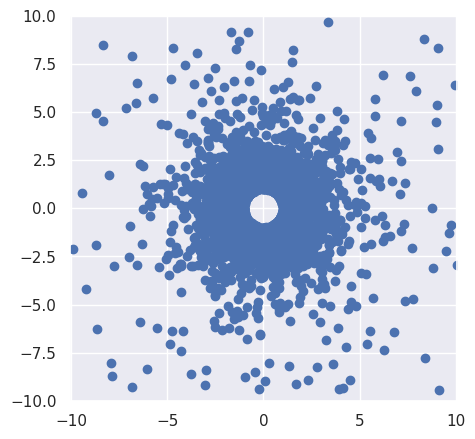

In [743]:
r = 1
mask =  np.sqrt(np.sum(np.power(Xs, 2),1)) > r

# X_1_c_mask = X_1_c[ r_k > r]
Xs_mask = Xs[mask]

fig,ax=plt.subplots(1, figsize=(5, 5))
ax.scatter(Xs_mask[:,0], Xs_mask[:,1])
lim  = 10
plt.axis('equal')
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
plt.show()

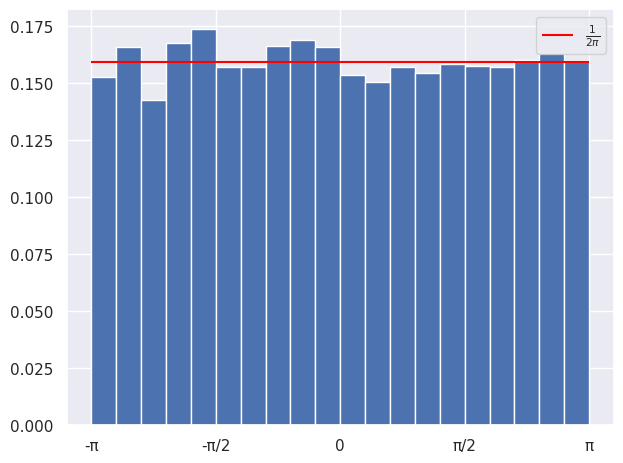

In [744]:
fig,ax=plt.subplots(1)

ax.hist(np.arctan2(Xs_mask[:,0], Xs_mask[:,1]) , xunits = radians, density= True, bins =20)
plt.xticks(np.arange(-pi, pi+pi/2, step=(pi/2)), ['-π','-π/2','0','π/2','π'])

fig.tight_layout()
plt.hlines(1/(2*pi) ,-pi, pi, colors= "red", label="$\\frac{1}{2\\pi}$")
plt.legend()
plt.show()

In [753]:
ts = np.linspace(0.1,2,100)
Z = gen_ecf(Xs, ts)[1]

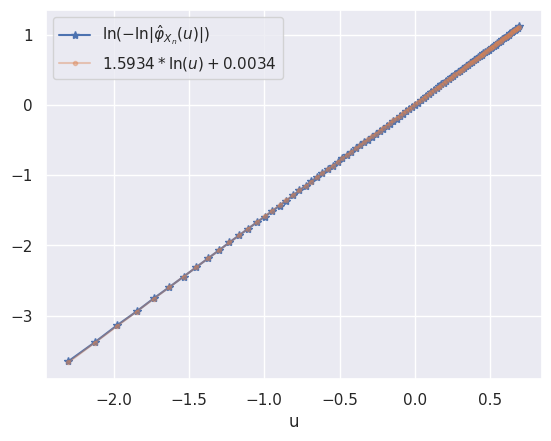

In [754]:
a, b = estym_alpha_from_cf(ts, Z)
plt.plot(np.log(ts), np.log(-np.log(np.abs(Z))), "*-", label = "$\ln(-\\ln |\\hat \\varphi_{X_n}(u)|)$")
plt.plot(np.log(ts), a*np.log(ts) + b,".-", label = "$%.4f*\\ln(u)+%.4f$"%(a,b), alpha = 0.4)
plt.xlabel("u")
plt.legend()
plt.savefig("latex/images/compare_cf.png")
plt.show()

In [757]:
ak_cf = np.array([sym_alpha_from_cf(alpha, beta, gamma, delta, sigma, n, ts)[0] for _ in range(1000)])
ak_cf = ak_cf[~np.isnan(ak_cf)]

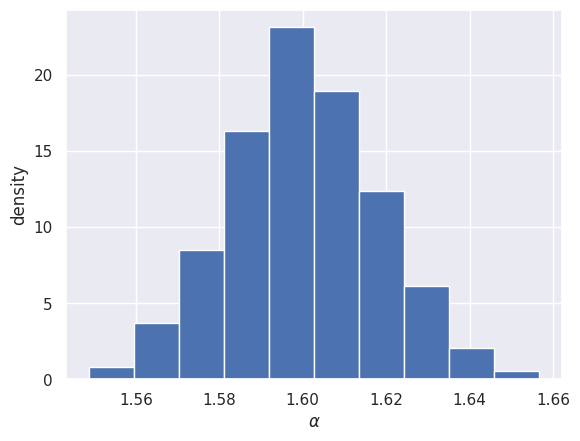

In [758]:
plt.hist(ak_cf, bins = 10, density=True)
plt.xlabel("$\\alpha$")
plt.ylabel("density")
plt.savefig("latex/images/cf_alpha_hist.png")
plt.show()

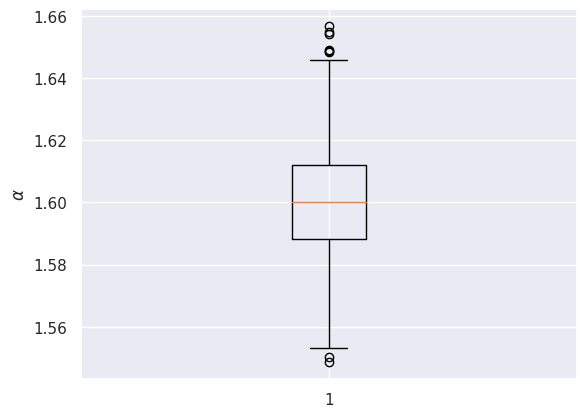

In [759]:
plt.boxplot(ak_cf[~np.isnan(ak_cf)])
plt.ylabel("$\\alpha$")
plt.savefig("latex/images/cf_alpha_boxplot.png")
plt.show()

In [760]:
print(pd.DataFrame(ak_cf).describe().T.to_latex())

\begin{tabular}{lrrrrrrrr}
\toprule
{} &   count &      mean &      std &       min &       25\% &       50\% &       75\% &       max \\
\midrule
0 &  1000.0 &  1.600277 &  0.01787 &  1.548667 &  1.588371 &  1.600269 &  1.612169 &  1.656737 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_9192/3939636250.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.DataFrame(ak_cf).describe().T.to_latex())


In [739]:
n = 1000
dt = 0.05
tmin = 0.5
tmax = 2
alpha = 1.6
beta = 1
gamma = np.cos(pi*alpha/4)**(2/alpha)
delta = 0
sigma = 1
d = 2
ts = np.arange(tmin, tmax, dt)

Xs_2d = sub_gaussian_SaS(alpha, beta, gamma, delta, sigma, size=[n, d])

In [700]:
ts = np.linspace(0.1,2,100)
Z = gen_ecf(Xs_2d, ts)[1]

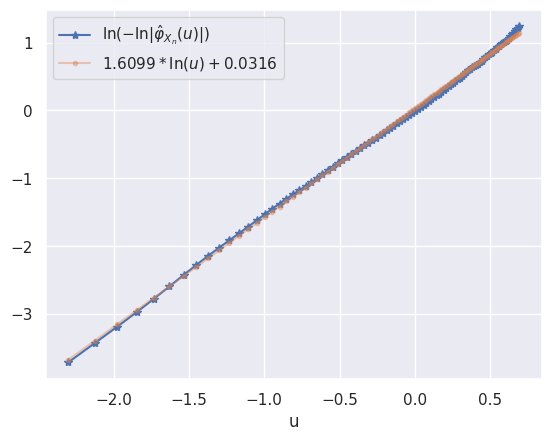

In [701]:
a, b  =np.polyfit(np.log(ts), np.log(-np.log(np.abs(Z))), 1)
plt.plot(np.log(ts), np.log(-np.log(np.abs(Z))), "*-", label = "$\ln(-\\ln |\\hat \\varphi_{X_n}(u)|)$")
plt.plot(np.log(ts), a*np.log(ts) + b,".-", label = "$%.4f*\\ln(u)+%.4f$"%(a,b), alpha = 0.4)
plt.xlabel("u")
plt.legend()
# plt.savefig("raport_1/latex/images/compare_cf.png")
plt.show()

In [731]:
xn = 100
yn = 100
lim = 3

ts = np.linspace(0.1,2,100)
XY, Z = gen_ecf(Xs_2d, ts)

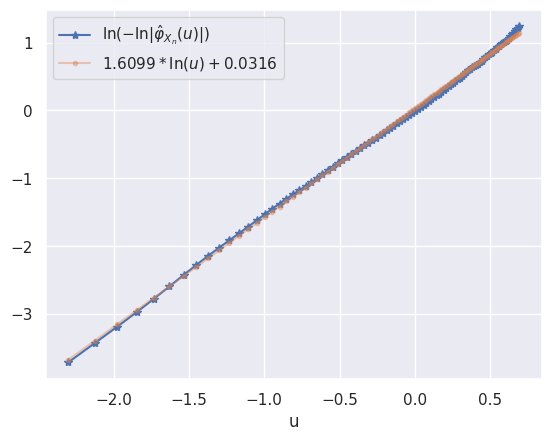

In [732]:
a, b  =np.polyfit(np.log(ts), np.log(-np.log(np.abs(Z))), 1)
plt.plot(np.log(ts), np.log(-np.log(np.abs(Z))), "*-", label = "$\ln(-\\ln |\\hat \\varphi_{X_n}(u)|)$")
plt.plot(np.log(ts), a*np.log(ts) + b,".-", label = "$%.4f*\\ln(u)+%.4f$"%(a,b), alpha = 0.4)
plt.xlabel("u")
plt.legend()
# plt.savefig("raport_1/latex/images/compare_cf.png")
plt.show()

In [678]:
xn = 100
yn = 100
lim = 3
xs = np.linspace(-lim, lim, xn)
ys = np.linspace(-lim, lim, yn)
ts_2d = np.array([ [x,y] for x in xs  for y in ys])
XY, Z = gen_ecf(Xs_2d, ts_2d)

In [679]:
xx,yy = np.meshgrid(xs, ys)
f = np.reshape(Z, (xn, yn)).T

(-3.0, 3.0)

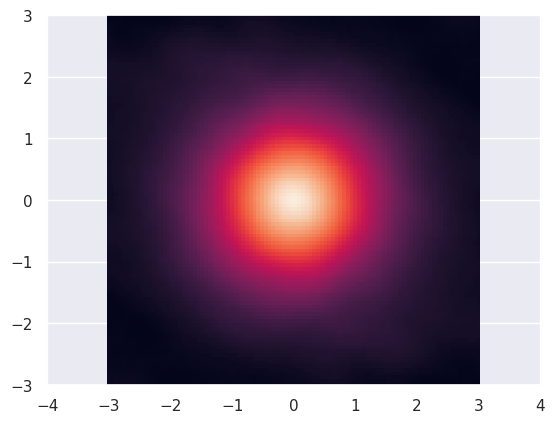

In [680]:
plt.pcolormesh(xx, yy, np.real(f))
lim = lim
plt.axis('equal')
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)

/home/olek/.local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


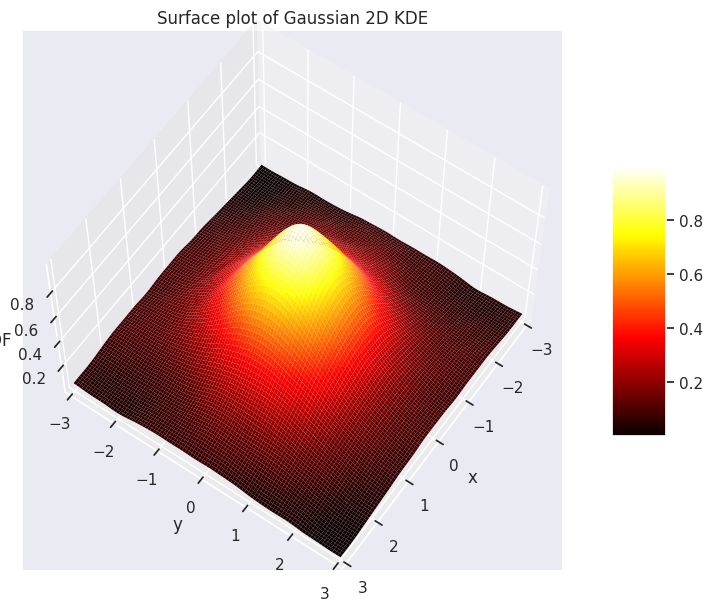

In [558]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx, yy, f, rstride=1, cstride=1, cmap='hot', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.show()

In [497]:
mask = (xx**2 + yy**2)<0.05

In [498]:
xx_copy = xx.copy()
yy_copy = yy.copy()
f_copy = f.copy()

In [503]:
xx_copy[mask] = None
yy_copy[mask] = None
f_copy[mask] = None

/home/olek/.local/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


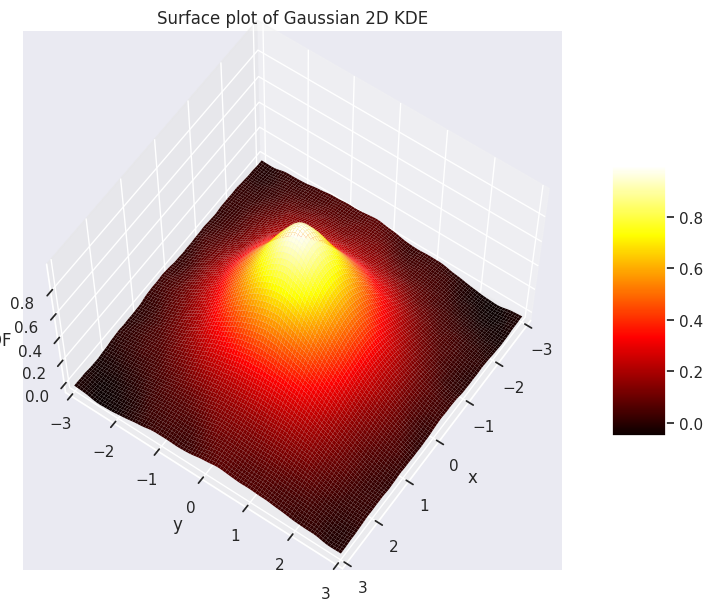

In [499]:
fig = plt.figure(figsize=(13, 7))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xx_copy, yy_copy, f_copy, rstride=1, cstride=1, cmap='hot', edgecolor='none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('PDF')
ax.set_title('Surface plot of Gaussian 2D KDE')
fig.colorbar(surf, shrink=0.5, aspect=5) # add color bar indicating the PDF
ax.view_init(60, 35)
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)
plt.show()

In [639]:
np.linspace(0,2*pi, 10)

array([0.        , 0.6981317 , 1.3962634 , 2.0943951 , 2.7925268 ,
       3.4906585 , 4.1887902 , 4.88692191, 5.58505361, 6.28318531])

In [668]:
xn = 100
yn = 100
lim = 3

rs = np.linspace(0.5, 2, 10)
args = np.linspace(0,2*pi,10)
for arg in args:
    xs = np.cos(arg)*rs
    ys = np.sin(arg)*rs
    xn, yn = len(xs), len(ys)
    ts_2d = np.array([ [x,y] for x in xs  for y in ys])
    XY, Z = gen_ecf(Xs, ts_2d )
    xx,yy = np.meshgrid(xs, ys)
    f = np.reshape(Z, (xn, yn)).T
    break

In [698]:
ts = np.linspace(0.1,2,100)
Z = gen_ecf(Xs_2d, ts)[1]

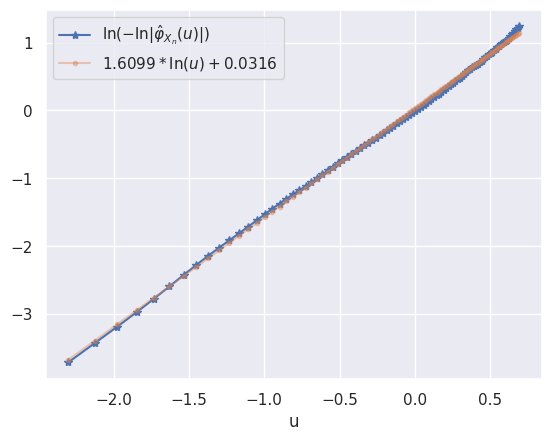

In [699]:
a, b  =np.polyfit(np.log(ts), np.log(-np.log(np.abs(Z))), 1)
plt.plot(np.log(ts), np.log(-np.log(np.abs(Z))), "*-", label = "$\ln(-\\ln |\\hat \\varphi_{X_n}(u)|)$")
plt.plot(np.log(ts), a*np.log(ts) + b,".-", label = "$%.4f*\\ln(u)+%.4f$"%(a,b), alpha = 0.4)
plt.xlabel("u")
plt.legend()
# plt.savefig("raport_1/latex/images/compare_cf.png")
plt.show()

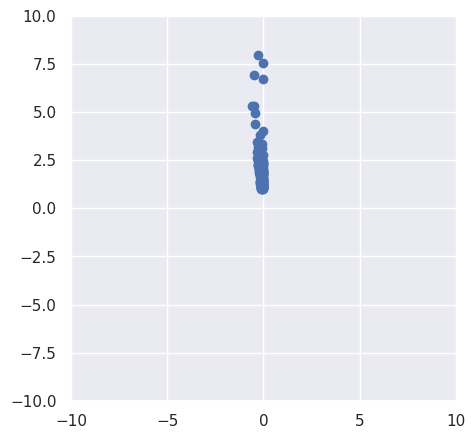

In [734]:
ys_hist, xs_hist , _ = ax.hist(np.arctan2(Xs_mask[:,0], Xs_mask[:,1]) , xunits = radians, density= True, bins =50)
ys[ys == max(ys) ]
index = np.argmax(ys_hist)
arg_min, arg_max = xs_hist[index], xs_hist[index+1]
args = np.arctan2(Xs_mask[:,0], Xs_mask[:,1])
mask_arg = (args > arg_min) & (args < arg_max)
Xs_mask_arg = Xs_mask[mask_arg]
fig,ax=plt.subplots(1, figsize=(5, 5))
ax.scatter(Xs_mask_arg[:,0], Xs_mask_arg[:,1])
lim  = 10
plt.axis('equal')
ax.set_xlim([-lim,lim])
ax.set_ylim([-lim,lim])
plt.show()